In [1]:
from math import *
from triqs.gf import *
from triqs.operators import *
from h5 import HDFArchive
import triqs.utility.mpi as mpi
import numpy as np
from triqs.plot.mpl_interface import plt,oplot
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})



Starting serial run at: 2022-09-24 21:17:48.165881


In [5]:
# fit the tail of the self energy for the magnetic order 
def fit_tail(S_iw, nmin, nmax, order = 4, known_moments= [], block = 'up_0', orb=0, xlim=(0,40), ylim=(-1.5,0.1)):

    beta =S_iw[block].mesh.beta

    mesh = np.array([w.imag for w in S_iw[block].mesh])

    S_iw_mfit = S_iw.copy()

    if not known_moments:
        shape = [0] + list(S_iw_mfit['up'].target_shape)

        known_moments = np.zeros(shape, dtype=np.complex)
        print("test",known_moments)

    o_min = (2*nmin+1)*np.pi/beta

    o_max = (2*nmax+1)*np.pi/beta
    for block, Gf_bl in S_iw_mfit:
        tail, err = S_iw_mfit[block].fit_hermitian_tail_on_window(n_min = nmin,
                                                      n_max = nmax ,
                                                      known_moments = known_moments,
                                                      n_tail_max = 2 * len(S_iw_mfit.mesh) ,
                                                      expansion_order = order)

        S_iw_mfit[block].replace_by_tail(tail,nmax)


        S_iw_mfit[block].replace_by_tail(tail,nmax)

    fig, (ax1) = plt.subplots(1,1,figsize=(10,6))

    ax1.axvline(x=o_min, color='k',label='window')
    ax1.axvline(x=o_max, color='k')

    ax1.plot(mesh,S_iw['up'][orb,orb].data.imag,'o',lw=3,label='raw',markersize=4)
    ax1.plot(mesh,S_iw_mfit['up'][orb,orb].data.imag,'-',lw=3,label='fit')

    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax1.set_ylabel(r"$Im \Sigma (i \omega)$")
    ax1.set_xlabel(r"$\omega$")

    ax1.legend(loc='lower right', ncol=1,numpoints=1,handlelength=1,fancybox=True,
               labelspacing=0.2,borderaxespad=0.5,borderpad=0.35,handletextpad=0.4)

    plt.show()

    return S_iw_mfit

Temp 0.1
Ut= 4


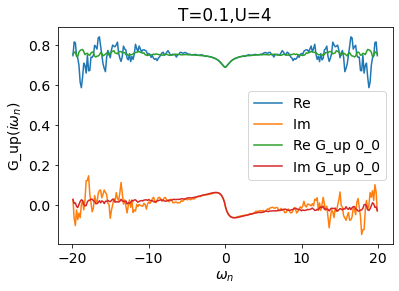

test []


/tmp/ipykernel_4024502/2612374069.py:13: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  known_moments = np.zeros(shape, dtype=np.complex)


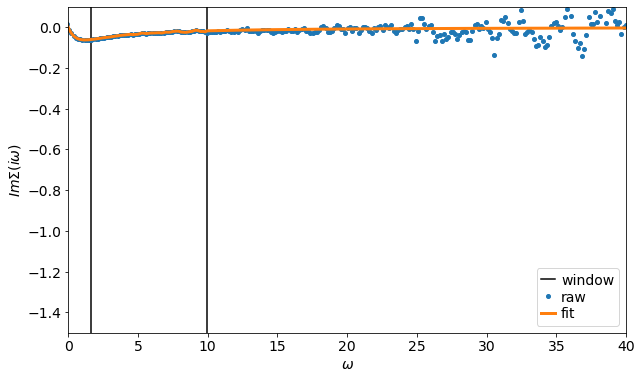

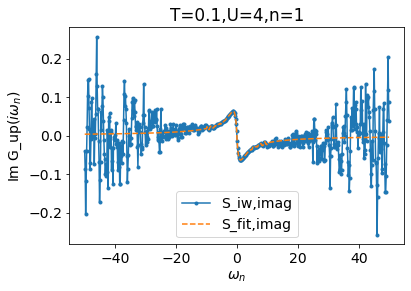

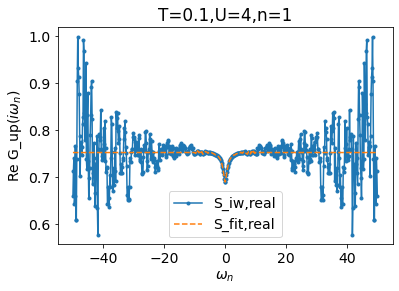

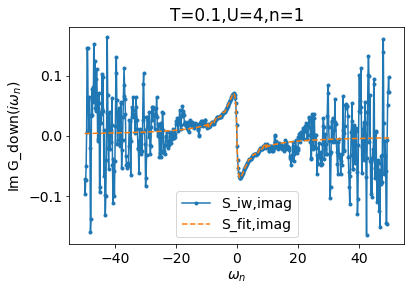

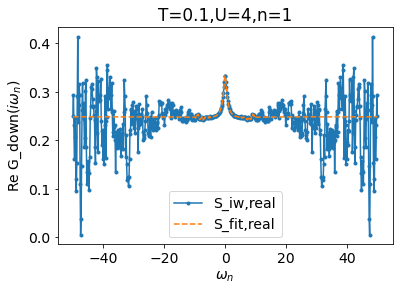

In [6]:

t=0.25
phi=1.5/12*pi+pi/3
ratio=0
for Ut in [4]:
    for density_required in [1]:
        filename="data/mag_ratio=%s_n=%s_phi=%s.h5"%(ratio,density_required,np.around(phi/pi,3))
        with HDFArchive(filename,'r') as A:
            n_loops=A['iterations']

        for Temp in [0.1]:
            beta=1/Temp/t
            print("Temp",Temp)
            print("Ut=", Ut)
            with HDFArchive(filename,'r') as A:
                mu=A['mu-T=%st_U=%st_%i'%(Temp,Ut,n_loops-1)]
                Sigma_up=GfImFreq(indices=[0], beta=beta)
                Sigma_down=GfImFreq(indices=[0], beta=beta)
                for i in range(1,6):
                    Sigma_up[0,0]+=(A['Sigma_iw-T=%st_U=%st_%i'%(Temp,Ut,n_loops-i)]['ferro'][0,0]+A['Sigma_iw-T=%st_U=%st_%i'%(Temp,Ut,n_loops-i)]['ferro'][0,1])/5
                    Sigma_down[0,0]+=(A['Sigma_iw-T=%st_U=%st_%i'%(Temp,Ut,n_loops-i)]['ferro'][0,0]-A['Sigma_iw-T=%st_U=%st_%i'%(Temp,Ut,n_loops-i)]['ferro'][0,1])/5
                Sigma = BlockGf(name_list=['up', 'down'], block_list=[Sigma_up, Sigma_down])
                oplot(A['Sigma_iw-T=%st_U=%st_%i'%(Temp,Ut,n_loops-6)]['ferro'][0,0]+A['Sigma_iw-T=%st_U=%st_%i'%(Temp,Ut,n_loops-6)]['ferro'][0,1],x_window  = (-20,20))
                oplot(Sigma['up'],x_window  = (-20,20))
                plt.legend()
                plt.title(f"T={Temp},U={Ut}")
                plt.show()

            beta =Sigma['up'].mesh.beta
            nmin=10
            if Temp>=0.2:
                nmin=4
            if Temp>=0.5:
                nmin=3
            nmax=int((10*beta/np.pi-1)/2)
            known_moments=[]

            S_fit=fit_tail(Sigma, nmin, nmax, order = 10, known_moments= known_moments, block = 'up', orb=0, xlim=(0,40), ylim=(-1.5,0.1))
            ## show the result
            for block, Gf_bl in Sigma:
                oplot(Sigma[block].imag,'.-',label=f"S_iw,imag",x_window  = (-50,50))
                oplot(S_fit[block].imag,'--',label=f"S_fit,imag",x_window  = (-50,50))
                plt.title(f"T={Temp},U={Ut},n={density_required}")
                plt.legend()
                plt.show()
                oplot(Sigma[block].real,'.-',label=f"S_iw,real",x_window  = (-50,50))
                oplot(S_fit[block].real,'--',label=f"S_fit,real",x_window  = (-50,50))
                plt.title(f"T={Temp},U={Ut},n={density_required}")
                #plt.axhline(y=Ut*t/2,linestyle="-.",color="black")
                plt.legend()
                plt.show()
#             with HDFArchive("data/fit_ratio=%s_phase_phi=%s_n=%s.h5"%(ratio,np.around(phi/pi,3),density_required)) as A:
#                 A['S_fit_iw-T=%st_U=%st'%(Temp,Ut)] = S_fit
#                 A['Sigma_iw-T=%st_U=%st'%(Temp,Ut)] = Sigma
#                 A['mu-T=%st_U=%st'%(Temp,Ut)]=mu
#                 #A['Tlist_U=%st'%(Ut)]=Tlist
            